# OECD data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#SSL-issues" data-toc-modified-id="SSL-issues-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SSL issues</a></span></li></ul></li><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Watermark</a></span></li></ul></li><li><span><a href="#OECD-inflation-data" data-toc-modified-id="OECD-inflation-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OECD inflation data</a></span><ul class="toc-item"><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Headline-inflation---selected-nations" data-toc-modified-id="Headline-inflation---selected-nations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Headline inflation - selected nations</a></span></li><li><span><a href="#Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)" data-toc-modified-id="Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Annualised and quarterly smoothed (using seasonally adjusted series)</a></span></li><li><span><a href="#Latest-CPI-components" data-toc-modified-id="Latest-CPI-components-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Latest CPI components</a></span></li></ul></li></ul></div>

## Notes

### SSL issues

From January 2023 I got the error message: SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED. 
I gather the immediate issue is changes to the openSSL library. But the more significant issue is with the OECD website.

To fix this issue, I:

* created a text file named ~/ssl.conf with the following content:

        openssl_conf = openssl_init
    
        [openssl_init]
        ssl_conf = ssl_sect
    
        [ssl_sect]
        system_default = system_default_sect

        [system_default_sect]
        Options = UnsafeLegacyRenegotiation

* added this line to my .zshrc file (because I use zsh as my shell): 

        export OPENSSL_CONF=~/ssl.conf

## Python setup

### Imports

In [1]:
# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasdmx import Request
from requests.exceptions import HTTPError

# system imports
from pathlib import Path
from datetime import date

# local imports
from finalise_plot import finalise_plot

### Settings

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# multi-time-period charts
TODAY = pd.Timestamp('today')
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)
MONTH_ADJ = 2 # months
RECENT = RECENT - pd.DateOffset(months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./charts/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)


### Watermark

In [3]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Jan 12 2023 10:27:30

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

seaborn   : 0.12.2
pandas    : 1.5.2
matplotlib: 3.6.2

Watermark: 2.3.1



## OECD inflation data

In [4]:
location_map = {
    'AUS':	'Australia',
    'AUT':	'Austria',
    'BEL':	'Belgium',
    'CAN':	'Canada',
    'CHL':	'Chile',
    'CZE':	'Czech Rep.',
    'DNK':	'Denmark',
    'EST':	'Estonia',
    'FIN':	'Finland',
    'FRA':	'France',
    'DEU':	'Germany',
    'GRC':	'Greece',
    'HUN':	'Hungary',
    'ISL':	'Iceland',
    'IRL':	'Ireland',
    'ISR':	'Israel',
    'ITA':	'Italy',
    'JPN':	'Japan', # missing most recent data
    'KOR':	'Korea',
    'LVA':	'Latvia',
    'LUX':	'Luxembourg',
    'MEX':	'Mexico',
    'NLD':	'Netherlands',
    'NZL':	'New Zealand',
    'NOR':	'Norway',
    'POL':	'Poland',
    'PRT':	'Portugal',
    'SVK':	'Slovak Rep.',
    'SVN':	'Slovenia',
    'ESP':	'Spain',
    'SWE':	'Sweden',
    'CHE':	'Switzerland',
    'TUR':	'Turkey', # Turkey 2022-11	84.389283	102.549467	123.340616
    'GBR':	'United Kingdom',
    'USA':	'United States',
    'ARG':	'Argentina',
    'BRA':	'Brazil',
    'CHN':	'China (PRC)',
    'COL':	'Colombia',
    'CRI':	'Costa Rica', # data issues
    'IND':	'India',
    'IDN':	'Indonesia',
    'LTU':	'Lithuania',
    'RUS':	'Russia',
    'SAU':	'Saudi Arabia',
    'ZAF':	'South Africa',
}

### Supporting functions

In [5]:
def build_key(locations, subject, measure, frequency, start):
    key = [locations, subject, measure, frequency]
    key_string = (
        f"{'.'.join(['+'.join(x) for x in key])}"
        f"/all?startTime={start}"
    )
    return key_string

In [6]:
# get the raw index data
def get_oecd_data(resource_id, key_string):
    oecd = Request('OECD')

    try:
        data = oecd.data(
            resource_id=resource_id,
            key=key_string,
        ).to_pandas()

    except HTTPError as err:
        data = pd.DataFrame()
          
    return data

In [7]:
# download the CPI data
def download_CPI_data(locations=location_map,
                      start='1969', 
                      subject_tuple=('CP18ALTT', 'CPALTT01'), 
                      measure='IXOB'):

    combined = pd.DataFrame()
    
    q_locations = {'AUS', 'NZL'}
    monthly = [x for x in locations if x not in q_locations]
    quarterly = [x for x in locations if x in q_locations]

    for locations, freq in zip((monthly, quarterly), ('M', 'Q')):
        for subject in subject_tuple:
            if not len(locations):
                continue
            key = build_key(locations, [subject], [measure], freq, start)
            data = get_oecd_data(resource_id='PRICES_CPI', key_string=key)
            if not len(data):
                continue
            data = data.unstack().T.droplevel(axis=1, level=[1, 2, 3])
            data.index = pd.PeriodIndex(data.index, freq=freq)
            if freq == 'Q':
                data = data.resample('M', convention='end').sum()
            #print(type(data), data.tail())
            combined = (
                data if not len(combined) 
                else pd.concat([combined, data], axis=1, join='outer')
            ).sort_index()
            #print(combined)
            locations = [x for x in locations if x not in data.columns]
            
    return combined

### Headline inflation - selected nations

In [8]:
chart_sets = {
    # Limit charts to 6 nations - otherwise they are too cluttered
    'of_interest': ['AUS', 'USA', 'CAN', 'DEU', 'GBR', 'JPN', ],
    'anglosphere': ['AUS', 'USA', 'CAN', 'NZL', 'GBR', 'IRL', ],
    'major_europe': ['FRA', 'DEU', 'ITA', 'GBR', 'RUS', 'ESP', ],
    'largest_economies': ['USA', 'CHN', 'JPN', 'DEU', 'GBR', 'IND', ],
    
    'asia': ['KOR', 'JPN', 'CHN', 'IND', 'IDN', ],
    'north_europe': ['DNK', 'SWE', 'NOR', 'ISL', 'FIN', 'GBR', ],
    'baltic_europe': ['LVA', 'LTU', 'EST', ],
    'central_europe': ['CZE', 'HUN', 'SVK', 'SVN', 'POL', 'GRC', ],
    'west_europe': ['ESP', 'PRT', 'NLD', 'LUX', 'FRA', 'BEL', ],
    'italo_germanic_europe': ['DEU', 'AUT', 'CHE', 'ITA', ],
    'turkey': ['TUR', ], # a high inflation outlier.
   
    'n_america': ['USA', 'CAN', 'MEX', ],
    'c_s_america': ['CHL', 'ARG', 'BRA', 'COL', 'CRI', ],

    'other': ['AUS', 'NZL', 'SAU', 'ZAF', 'ISR', ],
}

In [9]:
cpi = download_CPI_data()
#cpi.tail()

In [10]:
inflation = (
    cpi
    .pct_change(12, fill_method=None) # Note: default fill_method is nasty
    .interpolate(method='time', limit_area='inside') 
    * 100
)
#inflation.tail()

of_interest


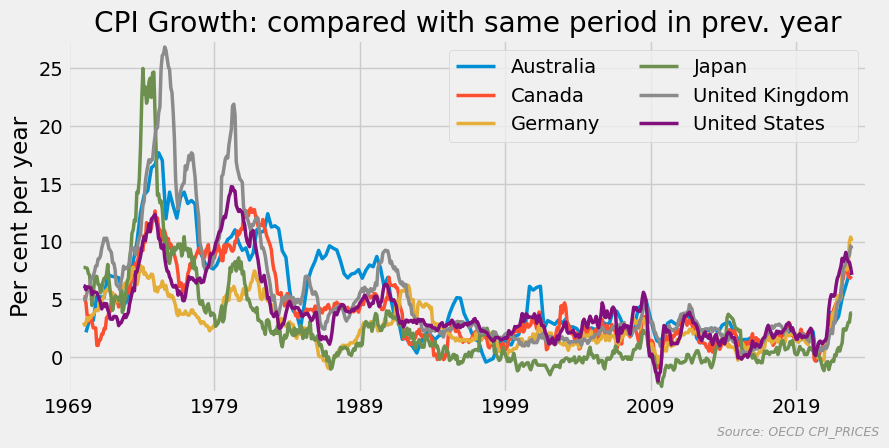

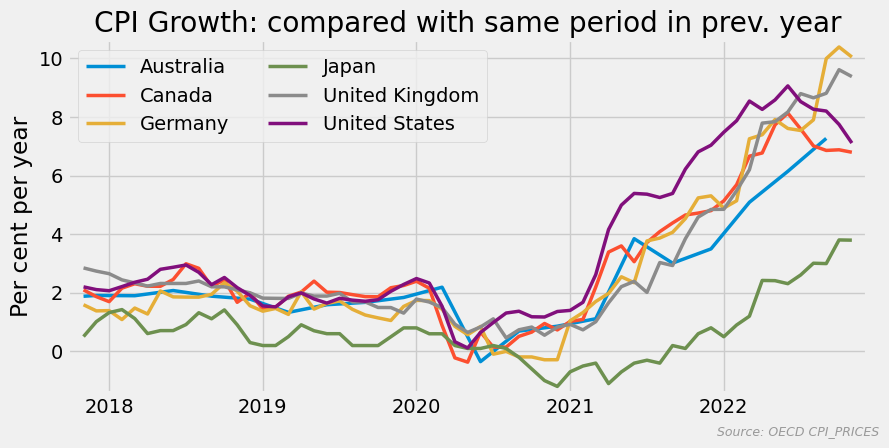

anglosphere


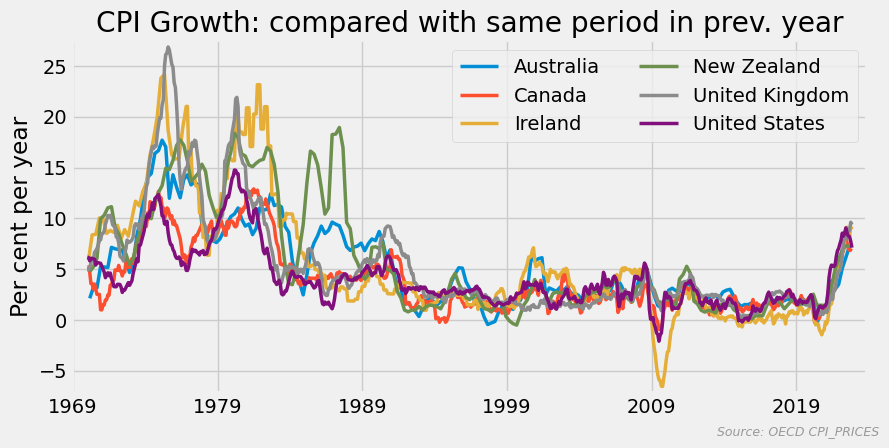

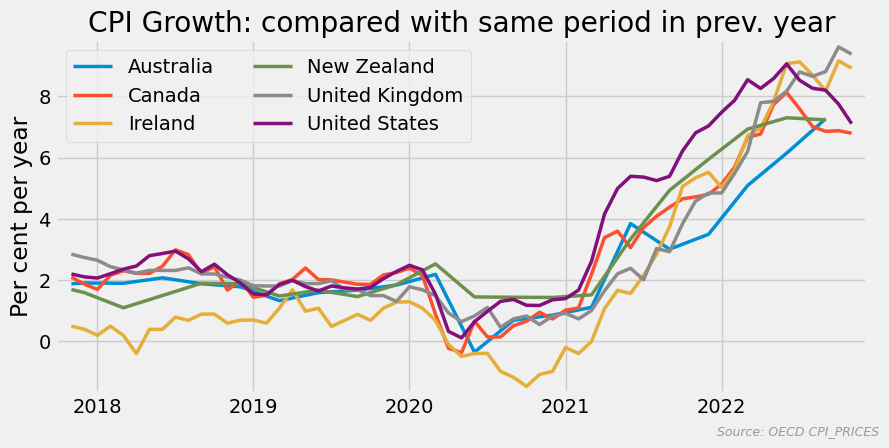

major_europe


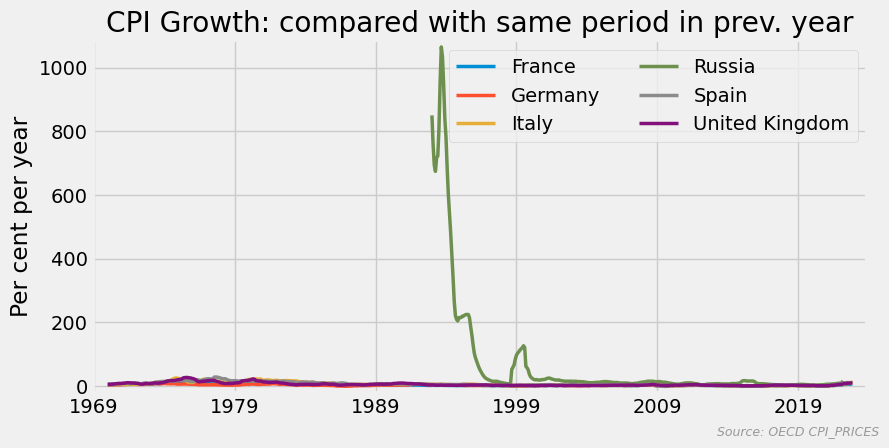

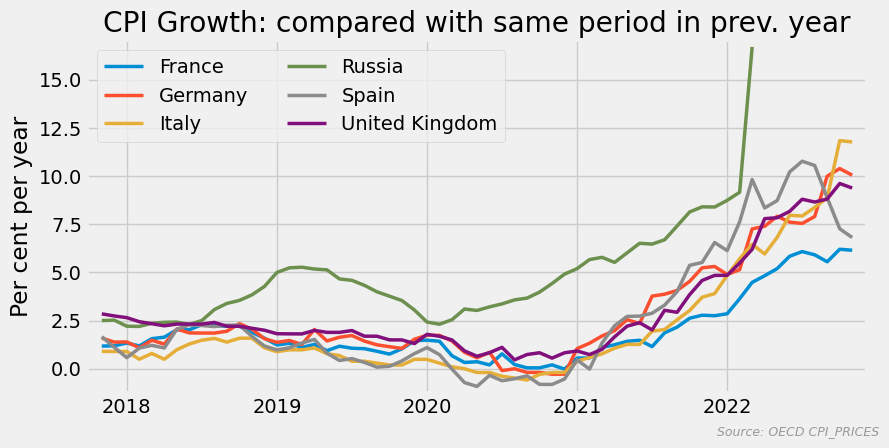

largest_economies


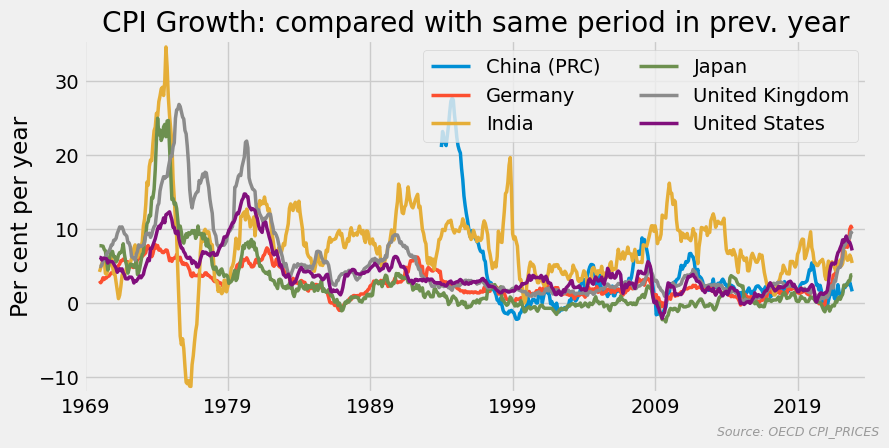

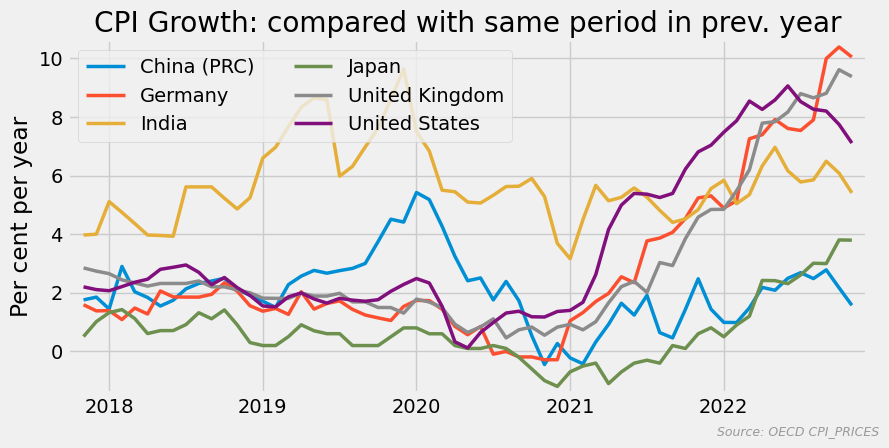

asia


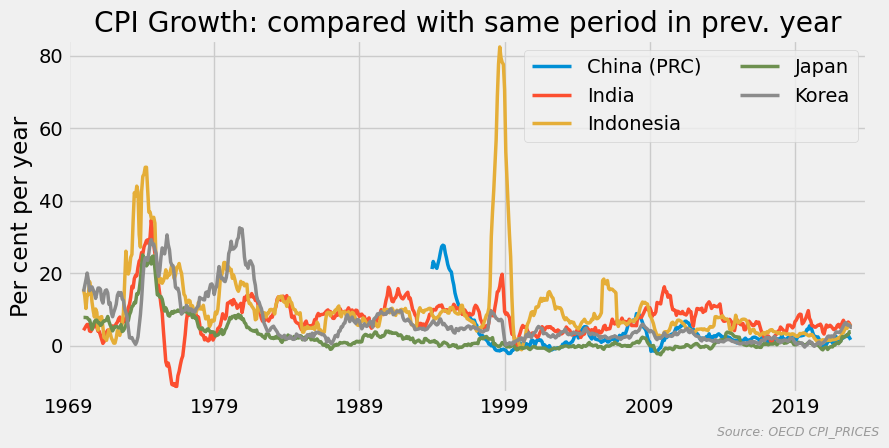

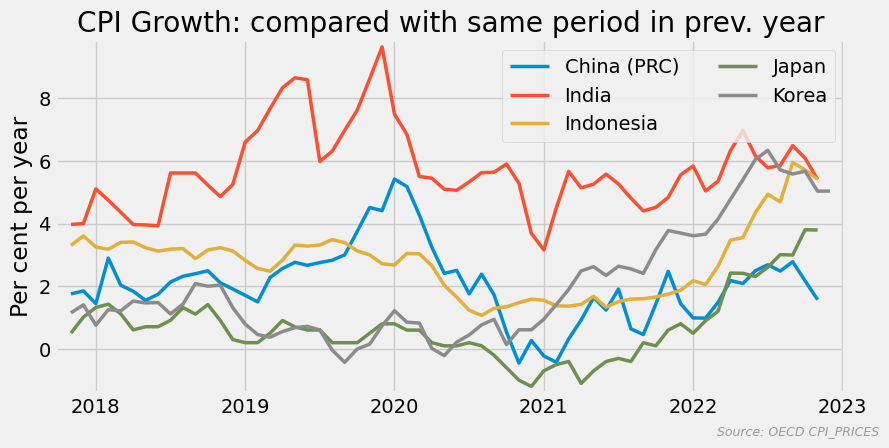

north_europe


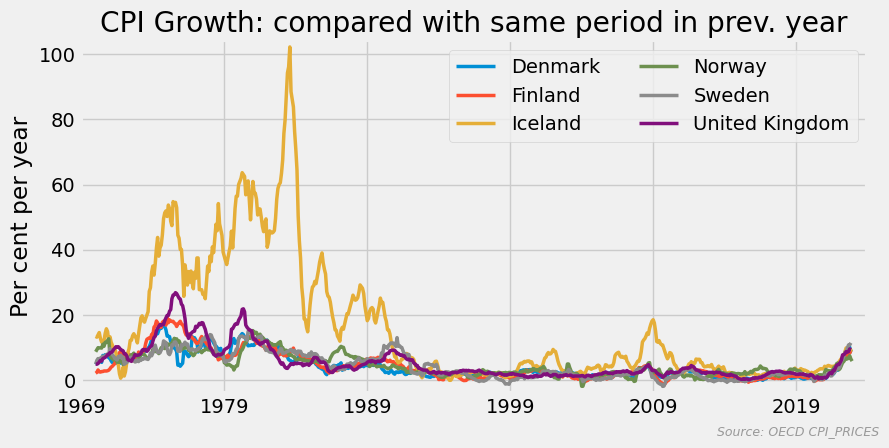

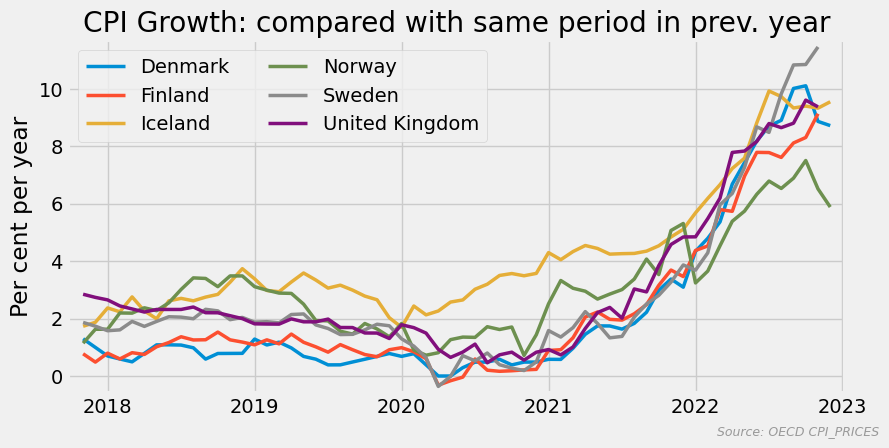

baltic_europe


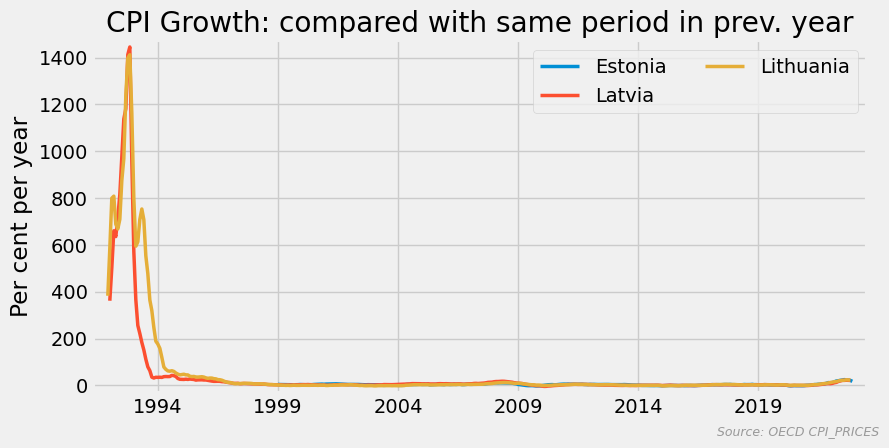

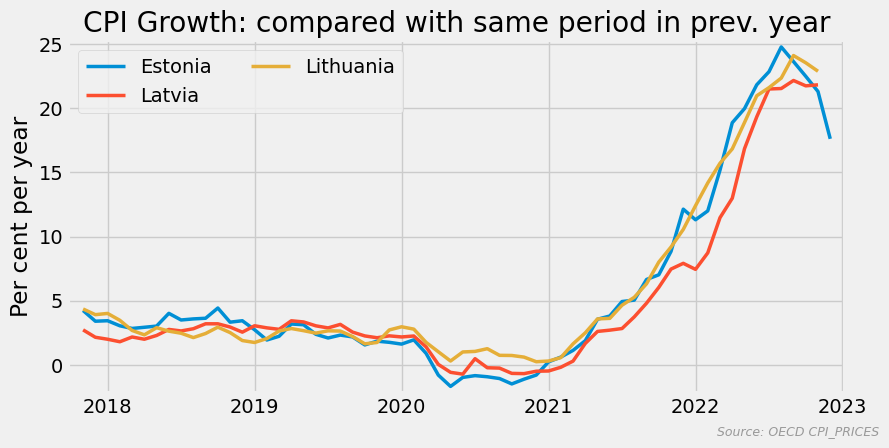

central_europe


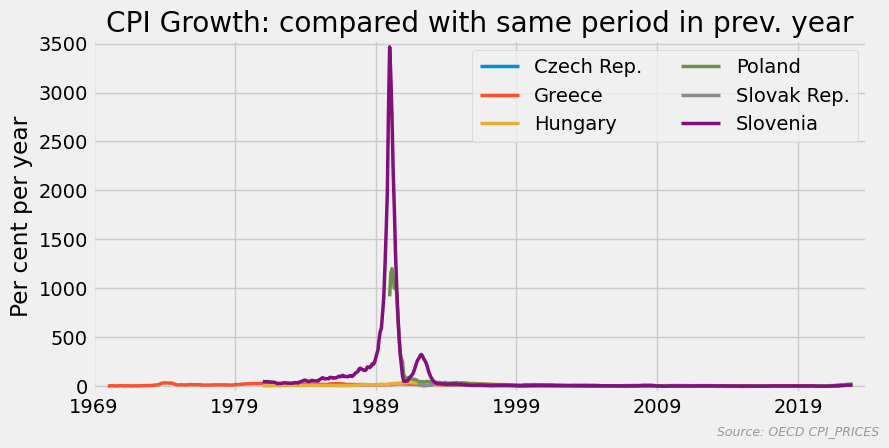

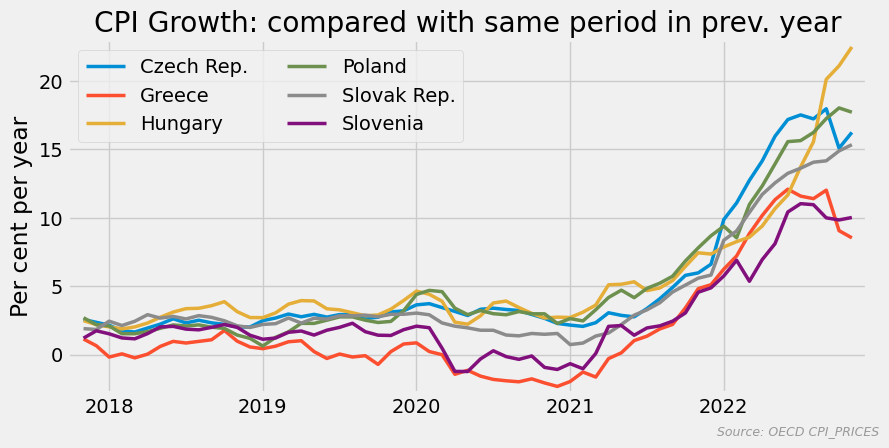

west_europe


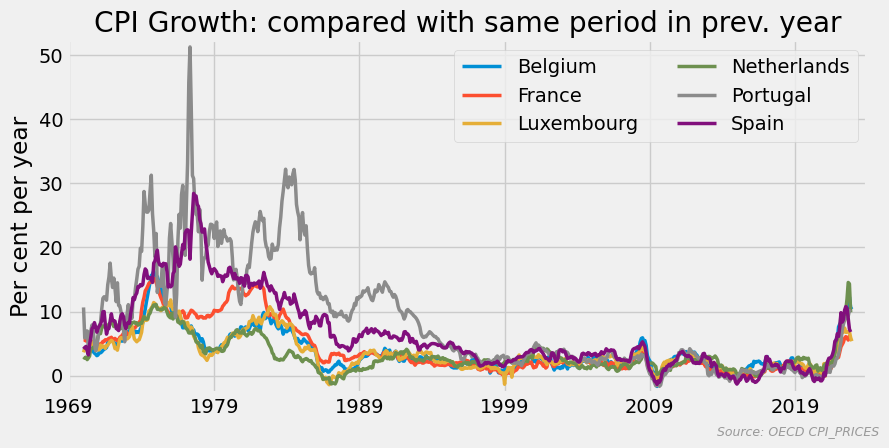

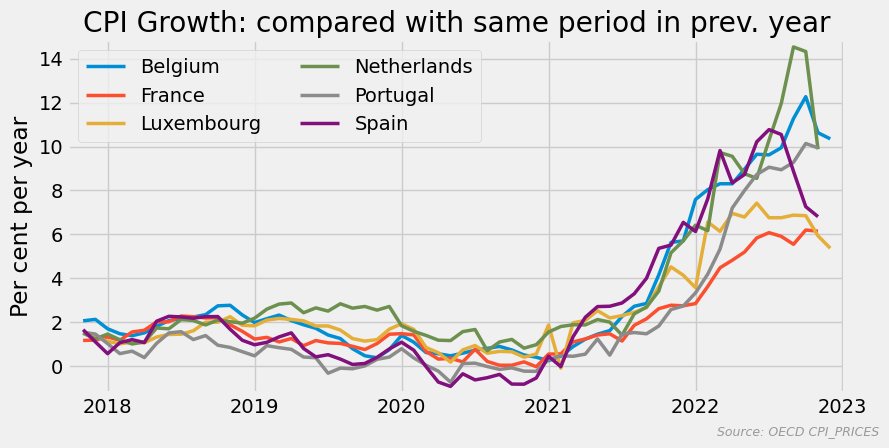

italo_germanic_europe


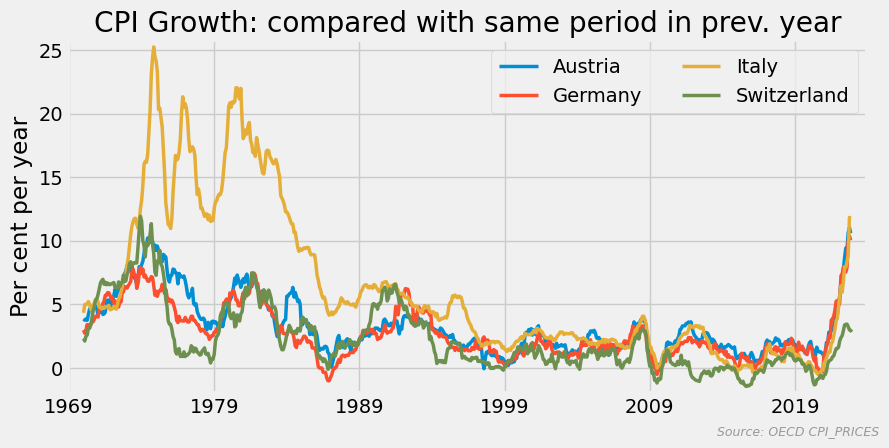

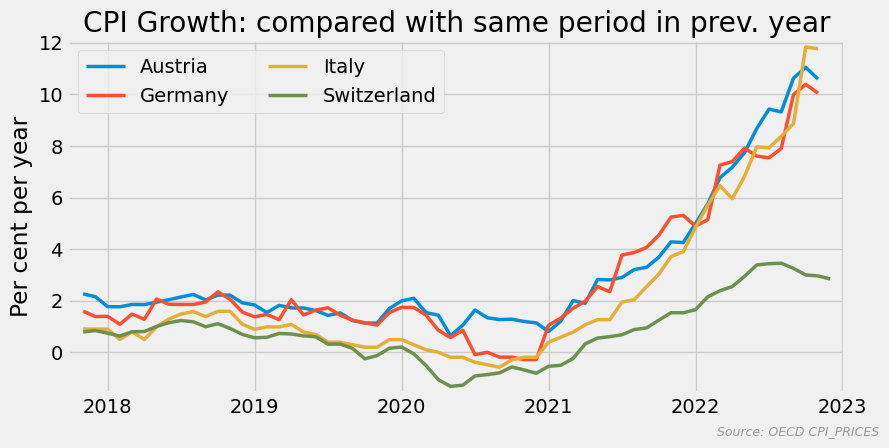

turkey


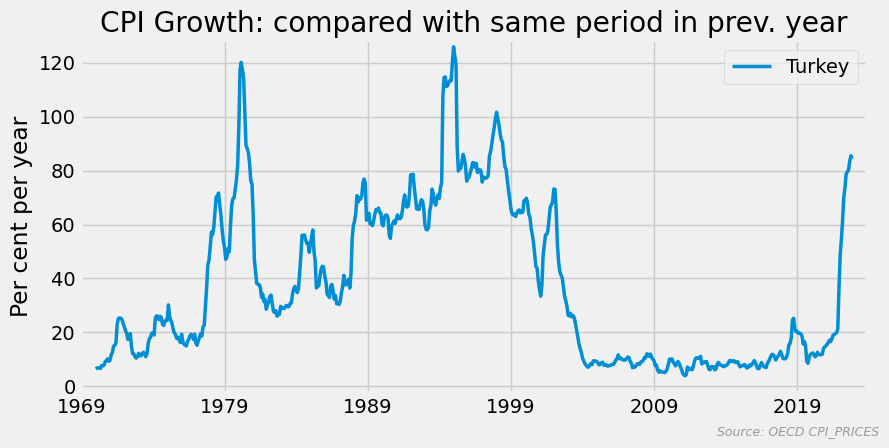

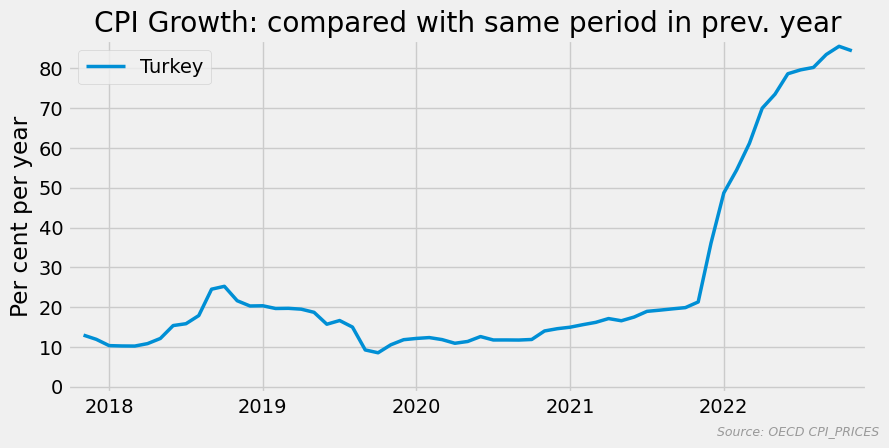

n_america


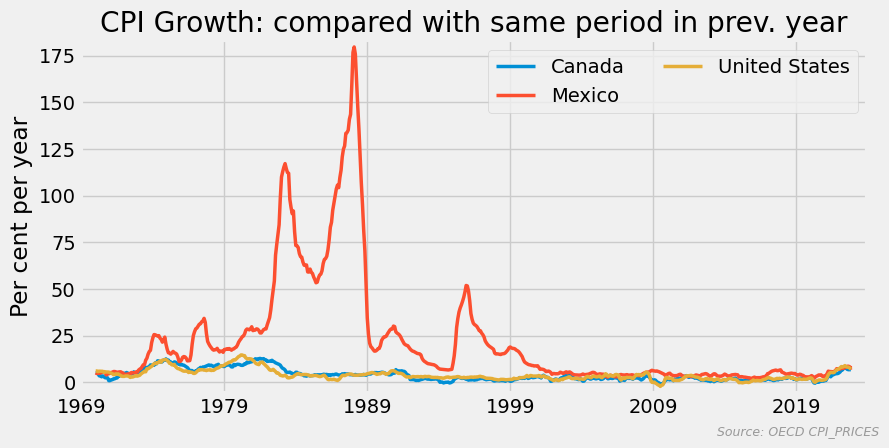

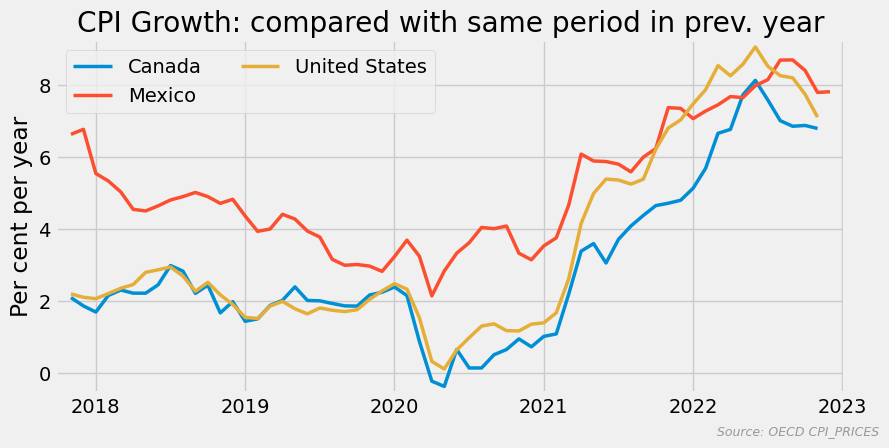

c_s_america


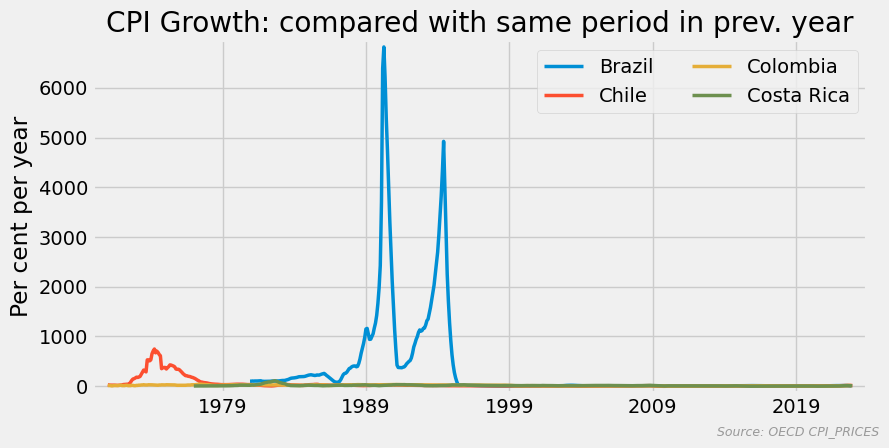

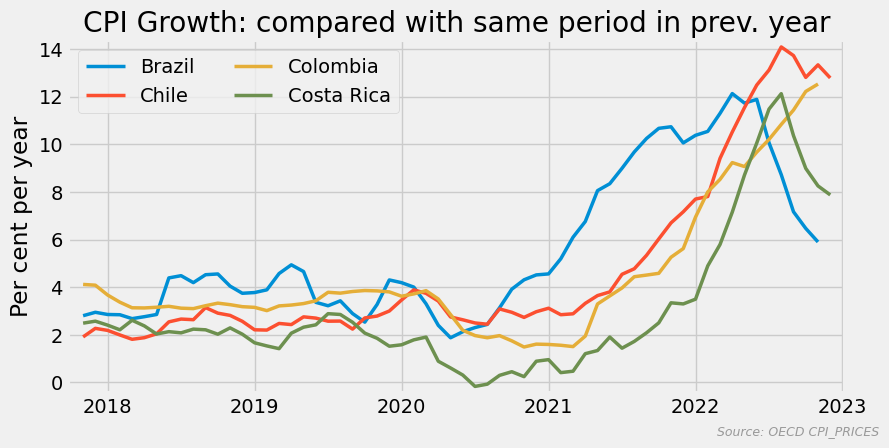

other


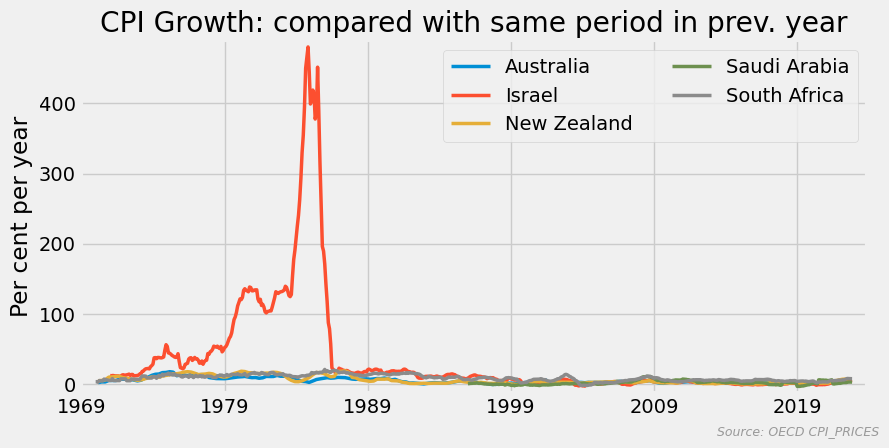

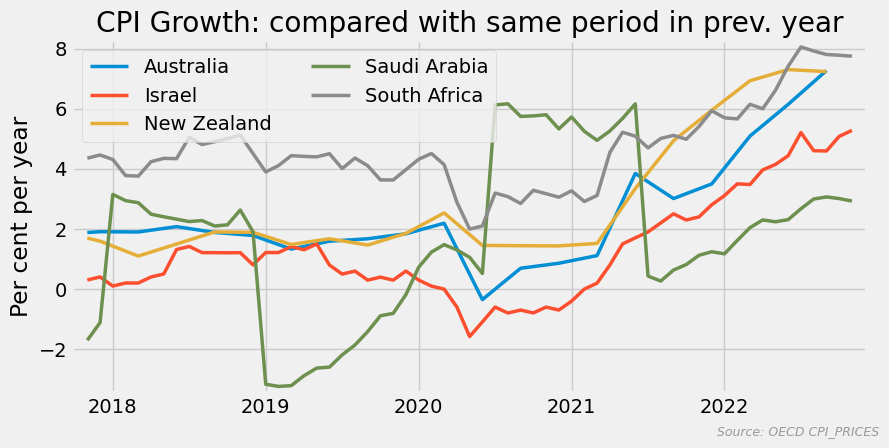

In [11]:
# plotting ...
title = 'CPI Growth: compared with same period in prev. year'
for label, locations in chart_sets.items(): 
    print(label)
    
    # get the data
    loc = [x for x in locations if x in inflation.columns]
    headline = inflation[loc].copy()
    headline = headline.rename(location_map, axis=1).sort_index(axis=1)

    # plot the data
    for start in None, RECENT:
        data = (
            headline if start is None 
            else headline[headline.index >= pd.Period(start, freq='M')]
        )
        ax = data.plot(lw=2.5)
        ax.legend(title=None, loc='best', ncol=2)
        tag = label if start is None else f'{label}-recent'

        finalise_plot(
            ax, title, 
            'Per cent per year', 
            tag, CHART_DIR,
            rfooter=f'{SOURCE} CPI_PRICES',
            zero_y=True,
            show=True,
        )

### Annualised and quarterly smoothed (using seasonally adjusted series)

In [12]:
locations = ['AUS', 'USA', 'CAN', 'DEU', 'JPN', ]
measure = 'IXOBSA'

cpi_sa = download_CPI_data(locations=locations,
                           start='1969',
                           measure=measure)

cpi_sa.tail()

LOCATION,JPN,CAN,DEU,USA,AUS
TIME_PERIOD,,,,,
2022-07,104.1486,120.3318,117.4706,124.5780,NaN
2022-08,104.4541,120.4109,118.1705,124.7252,NaN
2022-09,104.7595,120.8849,120.6698,125.2066,119.2477
2022-10,105.4721,121.5960,121.8695,125.7555,NaN
2022-11,105.7775,122.0701,122.2694,125.8766,NaN


In [13]:
inflation_sa_a = (
    cpi_sa
    .pct_change(3, fill_method=None) # Note: default fill_method is nasty
    .interpolate(method='time', limit_area='inside') 
    * 4 # quarters
    * 100 # per cent
)
inflation_sa_a.tail()

LOCATION,JPN,CAN,DEU,USA,AUS
TIME_PERIOD,,,,,
2022-07,2.755714,6.947047,5.172328,9.156745,7.166901
2022-08,3.143586,2.908441,3.757729,5.689565,7.231250
2022-09,3.925530,2.366905,13.002392,1.940900,7.295599
2022-10,5.083122,4.202380,14.978727,3.780764,NaN
2022-11,5.067872,5.511793,13.874529,3.692598,NaN


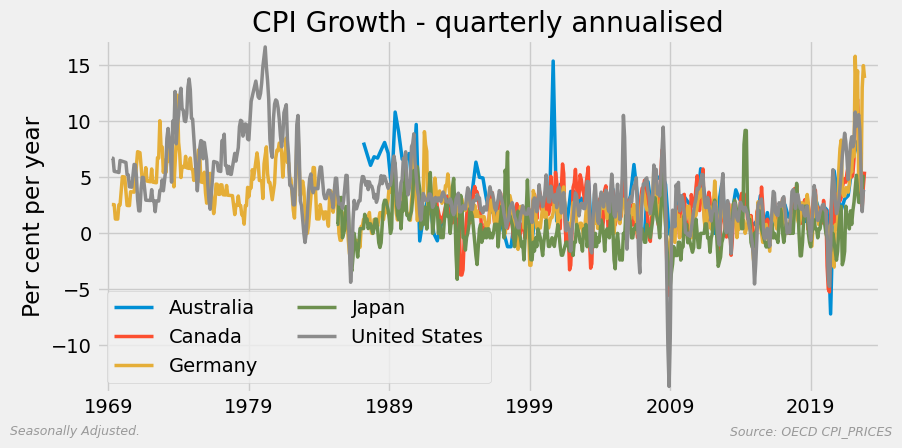

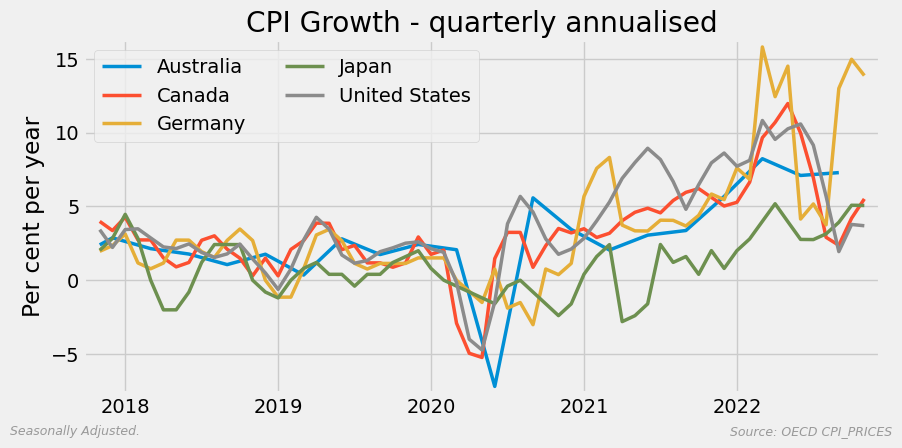

In [14]:
# plot 
title = 'CPI Growth - quarterly annualised'
for start in None, RECENT:
    data = (
        inflation_sa_a if start is None 
        else inflation_sa_a[inflation_sa_a.index >= pd.Period(start, freq='M')]
    )
    data = data.rename(location_map, axis=1).sort_index(axis=1)
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES',
        lfooter='Seasonally Adjusted.',
        show=True,
)

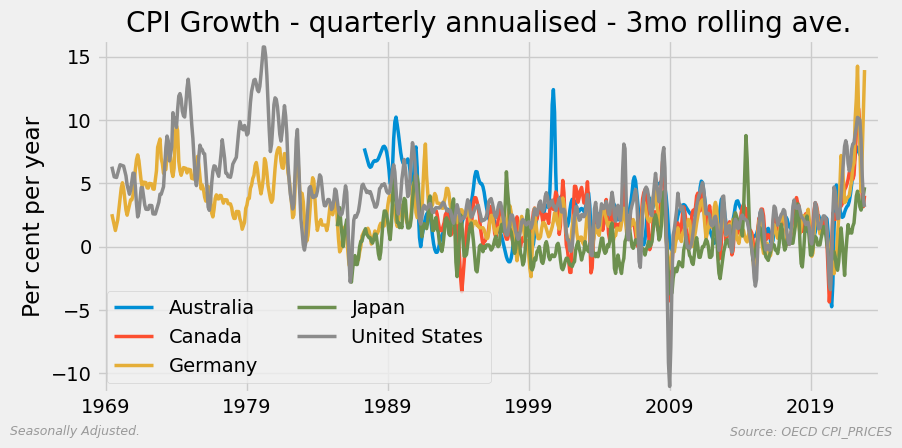

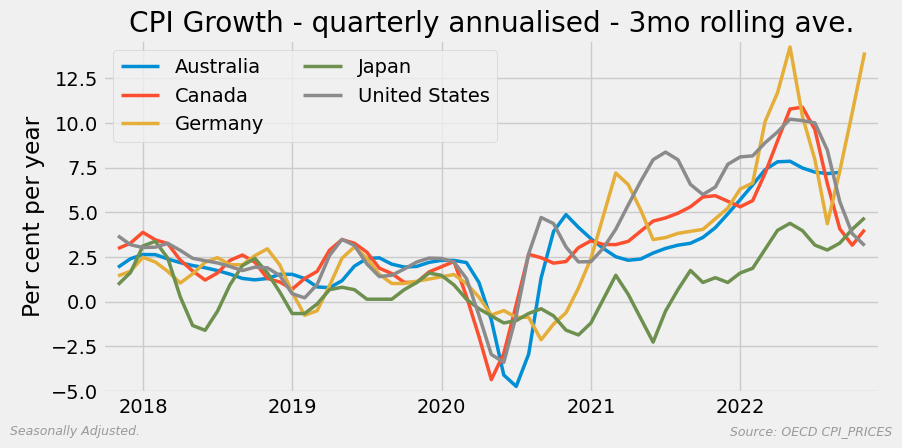

In [15]:
inflation_sa_a_3mora = inflation_sa_a.rolling(3).mean()
# plot 
title = 'CPI Growth - quarterly annualised - 3mo rolling ave.'
for start in None, RECENT:
    data = (
        inflation_sa_a_3mora if start is None 
        else inflation_sa_a_3mora[inflation_sa_a_3mora.index >= pd.Period(start, freq='M')]
    )
    data = data.rename(location_map, axis=1).sort_index(axis=1)
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES',
        lfooter='Seasonally Adjusted.',
        show=True,
)

### Latest CPI components

In [16]:
# set_up
all_items = ('CP18ALTT', 'CPALTT01')
food = ('CP180100', 'CP010000')
energy = ('CP18GREN', 'CPGREN01')
points = {
    'All items': all_items,
    'Food and non-alcoholic beverages': food,
    'Energy': energy,
}
locations = list(location_map.keys())
start = TODAY.year - 2
measure = 'IXOB'

In [17]:
frame = pd.DataFrame()
get_data_date = lambda series: str(pd.Period(series.last_valid_index(), freq='M'))
loop_count = 0

for component, subjects in points.items():
    cpi_x = download_CPI_data(start=start, subject_tuple=subjects)
    inf_x = (
        cpi_x
        .pct_change(12, fill_method=None) # Note: default fill_method is nasty
        * 100 # per cent
    )
    if not loop_count:
        latest_date = inf_x.apply(get_data_date)
        renamer = {x: f'{location_map[x]} {str(latest_date[x])[2:]}' for x in inf_x.columns}
    latest = inf_x.ffill().iloc[-1].rename(renamer)
    if not loop_count:
        latest = latest.sort_values()
    frame[component] = latest
    loop_count += 1

frame

,All items,Food and non-alcoholic beverages,Energy
LOCATION,,,
China (PRC) 22-11,1.573221,3.648867,NaN
Switzerland 22-12,2.840271,4.039991,16.205581
Saudi Arabia 22-11,2.928593,3.487492,NaN
Japan 22-11,3.796136,7.234960,13.399323
Korea 22-12,5.036453,5.229564,14.304626
Israel 22-11,5.278642,4.802922,4.350500
Luxembourg 22-12,5.374021,10.903785,13.158518
India 22-11,5.409730,NaN,NaN
Indonesia 22-11,5.418007,NaN,NaN


/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_85519/393438486.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=90, )


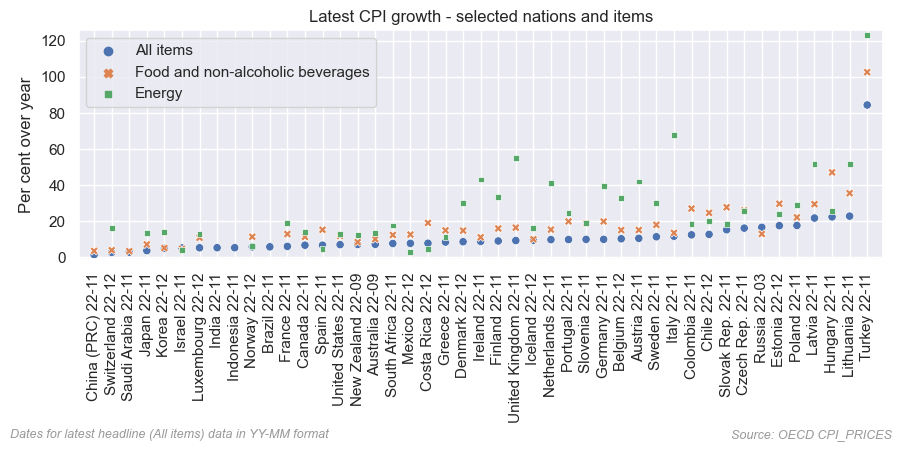

In [18]:
# ... and plot
sns.set(font_scale=1)
ax = sns.scatterplot(frame)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels, rotation=90, )
ax.legend(loc='upper left')

finalise_plot(
    ax, 
    'Latest CPI growth - selected nations and items', 
    'Per cent over year', 
    '', CHART_DIR,
    rfooter=f'{SOURCE} CPI_PRICES',
    lfooter='Dates for latest headline (All items) data in YY-MM format',
    show=True,
)